In [2]:
import numpy as np
import matplotlib as mp
from matplotlib import pyplot
#these two are for loop of image update
from IPython.display import clear_output
from time import sleep

completed=100% cost=12.444163237243599 rate=0.0001          
teaching finished


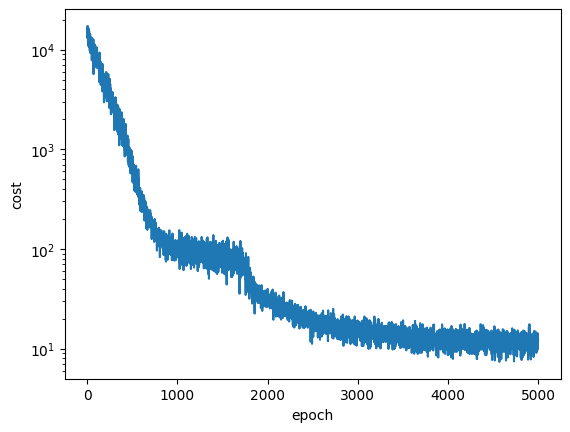

In [3]:
Nout=1 #output layer size
Nin=2 #input layer size
N=100 #hidden layer size
Nlay=2 #number of hidden layers

#auxiliary functions preparing data structures

def Y_size(i,val,num):
    if i==0:
        return np.array([[val for i in range(Nout)] for j in range(num)])
    elif 0<i<Nlay+1:
        return np.array([[val for i in range(N)] for j in range(num)])
    elif i==Nlay+1:
        return np.array([[val for i in range(Nin)] for j in range(num)])

def rand_size(i):
    s=1.0
    if i==0:
        return np.random.uniform(low=-s,high=s,size=[1,Nout])
    elif 0<i<Nlay+1:
        return np.random.uniform(low=-s,high=s,size=[1,N])
    elif i==Nlay+1:
        return np.random.uniform(low=-s,high=s,size=[1,Nin])

def set_Y(val,data_size):
    return [Y_size(i,val,data_size) for i in range(Nlay+2)]

def set_B(val):
    return [Y_size(i,val,1) for i in range(Nlay+1)]

def set_B_rand():
    return [rand_size(i) for i in range(Nlay+1)]

def set_Z(val,data_size):
    return [Y_size(i,val,data_size) for i in range(Nlay+1)]

def W_size(i,val):
    if i==0:
        return np.full((N,Nout),val)
    if 0<i<Nlay:
        return np.full((N,N),val)
    if i==Nlay:
        return np.full((Nin,N),val)
        
def W_size_rand(i):
    s=1.5
    if i==0:
        return np.random.uniform(low=-s,high=s,size=[N,Nout])
    if 0<i<Nlay:
        return np.random.uniform(low=-s,high=s,size=[N,N])
    if i==Nlay:
        return np.random.uniform(low=-s,high=s,size=[Nin,N])

#functions return a list of matrices of weights for all layers
def set_W(val):
    return [W_size(i,val) for i in range(Nlay+1)]

def set_W_rand():
    return [W_size_rand(i) for i in range(Nlay+1)]

#activation function and its derivative
def f(z):
    return z*(z>0)#1.0/(1.0+np.exp(-z))

def df(z):
    return (z>0)#np.exp(-z)/(1.0+np.exp(-z))**2

#NN output for input data x, parameters:
#w - NN weights, b - NN biases, y - is set to output of each NN layer, z, dz - are set to auxiliary layer outputs,
#x - input, f - weighting function, df - weighting function derivative
def network_output(w,b,y,z,dz,x,f,df):
    y[Nlay+1]=x
    #print(type(y[Nlay+1]))
    for i in range(Nlay,-1,-1):
        #print(i)
        z[i]=np.dot(y[i+1],w[i])+b[i] #it dim z>dim b, but it is special behavior of array that it works as intended
        #print("in network z:", z[i])
        dz[i]=df(z[i])
        y[i]=f(z[i])
        #if i!=0:
        #    y[i]=f(z[i])
        #else:
        #    y[i]=z[i]
            #y[i]=f(z[i])
        #print(y[i])

#function defining the image:
def manifold(vec):
    x=vec[0]
    y=vec[1]
    return 10.0*(x**2+y**2<4.0)+20.0*((x-1.0)**2+(y-0.2)**2<0.75**2)+20.0*((x+1.0)**2+(y-0.2)**2<0.75**2)-10.0*(x**2+(y+1.3)**2<0.7**2)
    #return (2.0*np.exp(-((x-2.0)**2+(y-1.0)**2)/0.1)+1.0*np.exp(-((x+2.0)**2+(y+2.0)**2)/0.25))+1.5*(x**2+y**2<4.0)

#generating full training data
points=np.arange(-2.5,2.5,0.05)
X_training=np.array([[x1,x2] for x1 in points for x2 in points])
Y_training=np.array([[manifold(v)] for v in X_training])

#W=set_W(1.0)
#B=set_B(0.0)
Y=set_Y(0,1)
Z=set_Z(0,1)
dZ=set_Z(0,1)
W=set_W_rand()
B=set_B_rand()

def cost_function(W,B,Xtr,Ytr):
    num=len(Xtr)
    Ytmp=set_Y(1.0,num)
    Ztmp=set_Z(1.0,num)
    dZtmp=set_Z(1.0,num)
    network_output(W,B,Ytmp,Ztmp,dZtmp,Xtr,f,df) #caculates num outputs at once!
    return ((Ytr[0]-Ytmp[0])**2).sum()/num

def print_cost_fun(cost_data):
    x=np.arange(0,len(cost_data),1)
    y1=cost_data
    pyplot.yscale("log")
    pyplot.plot(x,y1)
    pyplot.xlabel("epoch")
    pyplot.ylabel("cost")
    pyplot.show()

#performs teaching of NN on a batch of training data, implements backpropagation and ADAM
def backpropagation(Xtr,Ytr,W,B,r,M,Mb,V,Vb,it):
    num=len(Xtr)
    delta_W=set_W(0.0)
    delta_B=set_B(0.0)
    Y=set_Y(1.0,num)
    Z=set_Z(1.0,num)
    dZ=set_Z(0.0,num)
    beta1=0.9
    beta2=0.99

    #print("it=",it,"Y:",Y,"Z",Z,"dZ",dZ)
    network_output(W,B,Y,Z,dZ,Xtr,f,df)
    #print("it=",it,"Y:",Y,"Z",Z,"dZ",dZ)
    delta=(Y[0]-Ytr)*dZ[0]
    #step 0
    delta_W[0]+=np.dot(np.transpose(Y[1]),delta)
    #print(delta, Y[1])
    delta_B[0]+=delta.sum(0)
    #other steps
    for n in range(1,len(W)):
        #print("n=",n)
        #update delta_W[n]
        delta=np.dot(delta,np.transpose(W[n-1]))*dZ[n]
        delta_W[n]=np.dot(np.transpose(Y[n+1]),delta)
        delta_B[n]=delta.sum(0)
        #print(np.shape(W[n]),np.shape(delta_W[n]))
    
    for n in range(len(W)):
        M[n]=beta1*M[n]+(1.0-beta1)*delta_W[n]/num
        Mb[n]=beta1*Mb[n]+(1.0-beta1)*delta_B[n]/num
        V[n]=beta2*V[n]+(1.0-beta2)*(delta_W[n]/num)**2
        Vb[n]=beta2*Vb[n]+(1.0-beta2)*(delta_B[n]/num)**2
        W[n]=W[n]-r*M[n]/(1.0-beta1**it)/(np.sqrt(V[n]/(1.0-beta2**it))+10**(-8))
        B[n]=B[n]-r*Mb[n]/(1.0-beta2**it)/(np.sqrt(Vb[n]/(1.0-beta2**it))+10**(-8))
    
    #print("from backprop, M",M)#"Mb",Mb,"V",V,"Vb",Vb,"W",W,"B",B)
    #for n in range(len(W)):
    #    W[n]-=r*delta_W[n]/num
    #    B[n]-=r*delta_B[n]/num
    return (((Y[0]-Ytr)**2)).sum()/num
        
def teach_network(W,B,Xtr,Ytr,Niter,sample_size,rate):
    xmax=2.5
    cost=[0.0 for i in range(Niter)]
    M=set_W(0.0)
    Mb=set_B(0.0)
    V=set_W(0.0)
    Vb=set_B(0.0)
    for n in range(1,Niter+1):
        #print("it=",n,"M:",M)#"Mb",Mb,"V",V,"Vb",Vb,"W",W,"B",B)
        #here I make batch of random training points
        tmpXtr=np.random.uniform(-xmax,xmax,[sample_size,2])
        tmpYtr=np.array([[manifold(v)] for v in tmpXtr])
        #backpropagation:
        cost[n-1]=backpropagation(tmpXtr,tmpYtr,W,B,rate,M,Mb,V,Vb,n)
        
        print(f"completed={(n)/Niter:.0%} cost={cost[n-1]:} rate={rate:.3}",end="          \r")
        #plot_x=[el[0] for el in tmpXtr]
        #plot_y=[el[1] for el in tmpXtr]
        #plot_z=tmpYtr
        #fig, ax=pyplot.subplots()
        #ax.scatter(plot_x,plot_y,c=plot_z,s=10)
        #pyplot.show()
    print("\nteaching finished")
    #print(cost)
    return cost

#print("W:",W, "B:", B)
cost_data=teach_network(W,B,X_training,Y_training,5000,200,0.0001)
print_cost_fun(cost_data)
#network_output(W,B,Y,Z,dZ,np.array([[1.0,-1.0]]),f,df)
#print("after:",W)
#print("B:", B)
#print("W:",W)

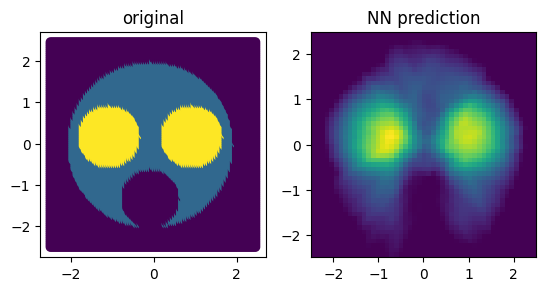

In [17]:
#visualize NN prediction
xmax=2.5
res=50
plot_x,plot_y=np.meshgrid(np.linspace(-xmax,xmax,res),np.linspace(-xmax,xmax,res))

def from_NN(W,B,Xin):
    num=len(Xin)
    Ytmp=set_Y(1.0,num)
    Ztmp=set_Z(0.0,num)
    dZtmp=set_Z(0.0,num)
    network_output(W,B,Ytmp,Ztmp,dZ,Xin,f,df)
    return Ytmp[0]

#visualize the original data
plot_x_org=[el[0] for el in X_training]
plot_y_org=[el[1] for el in X_training]
plot_z_org=Y_training



plot_len=len(plot_x)

fig=pyplot.figure()
plot=fig.add_gridspec(1,2)
ax=plot.subplots()

plot_z_NN_tmp=from_NN(W,B,np.array([[plot_y[i,j],plot_x[i,j]] for j in range(len(plot_x)) for i in range(len(plot_x))]))
plot_z_NN=[plot_z_NN_tmp[i*plot_len:(i+1)*plot_len-1] for i in range(plot_len)]

ax[0].scatter(plot_x_org,plot_y_org,c=plot_z_org)
ax[0].set_title("original")
ax[0].set_aspect(1)
ax[1].imshow(plot_z_NN,origin='lower',extent=[-xmax,xmax,-xmax,xmax],interpolation='nearest')
ax[1].set_title("NN prediction")
ax[1].set_aspect(1)
pyplot.show()


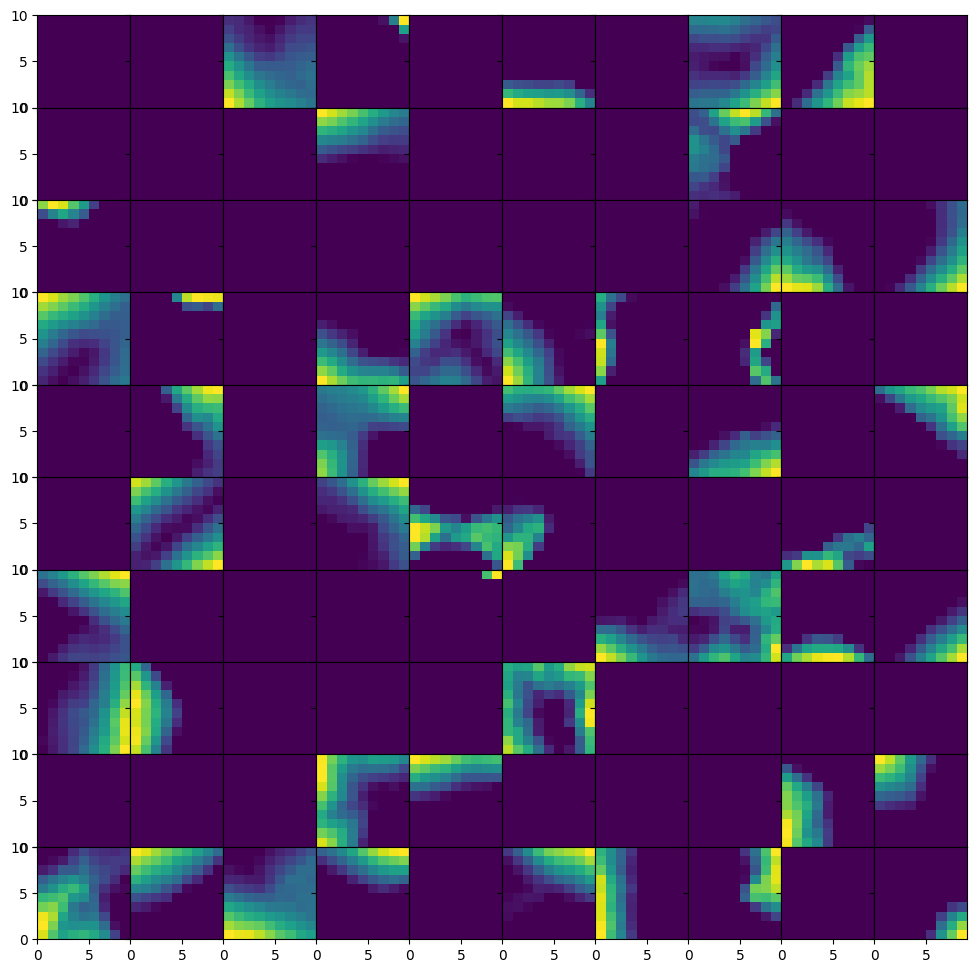

In [18]:
#visualize the effects of neurons
#this code shows a prediction of NN when one neuron in a given *layer* is knocked off or when all neurons except one are knocked off
#The results are organized in a grid of plots, parameters: layer - layer which will be knocked out, gridN - size of plot grid, ideally grindN=N^2
xmax=2.5
res=10
gridN=10
layer=0
plot_x,plot_y=np.meshgrid(np.linspace(-xmax,xmax,res),np.linspace(-xmax,xmax,res))
plot_len=len(plot_x)

fig=pyplot.figure(figsize=(12,12))
plot=fig.add_gridspec(gridN,gridN,hspace=0,wspace=0)
grid=plot.subplots(sharex='col',sharey='row')

for k in range(gridN):
    for l in range(gridN):
        Wtmp=W[:] #this makese copy of W
        
        #knockout one neuron
        #Wtmp[layer]=np.array([[W[layer][i,0]] if i!=10*k+l else [0] for i in range(len(W[layer]))])
        
        #knockout all except one neuron
        Wtmp[layer]=np.array([[0] if i!=10*k+l else [W[layer][i,0]] for i in range(len(W[layer]))])
        
        plot_z_NN=from_NN(Wtmp,B,np.array([[plot_y[i,j],plot_x[i,j]] for j in range(len(plot_x)) for i in range(len(plot_x))]))
        plot_z_NN=plot_z_NN.flatten()
        
        #print(plot_z_NN)
        plot_z_NN=[plot_z_NN[(i*plot_len):((i+1)*plot_len-1)] for i in range(plot_len)]
        #print(plot_z_NN)
        #plot_z_NN=[[i**2+j**2 for i in range(plot_len)] for j in range(plot_len)]
        grid[k,l].pcolormesh(plot_z_NN)#,origin='lower',extent=[-xmax,xmax,-xmax,xmax],interpolation='nearest')
        #grid[k,l].set_aspect(1)

#grid.imshow(plot_z_NN,origin='lower',extent=[-xmax,xmax,-xmax,xmax],interpolation='nearest')
pyplot.show()

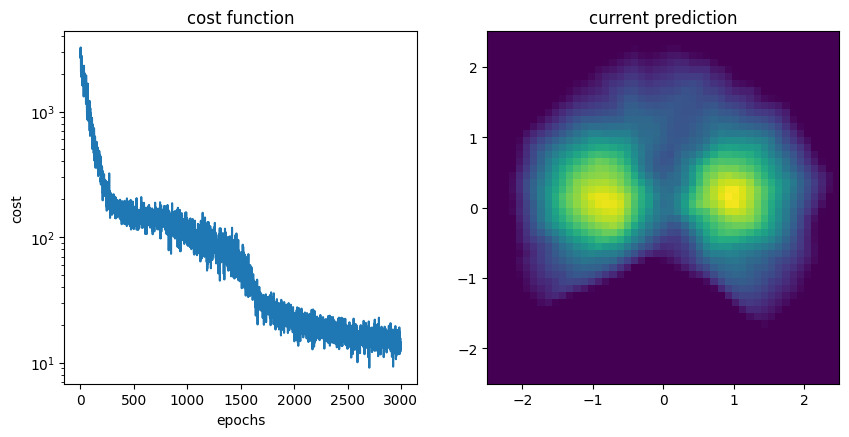


teaching finished


In [20]:
#dynamically visualize network teaching progress:

tabW=[set_W_rand()]
tabB=[set_B_rand()]

def vis_teach_network(W,B,epochN,Niter,sample_size,rate):
    xmax=2.5
    res=50
    plot_x,plot_y=np.meshgrid(np.linspace(-xmax,xmax,res),np.linspace(-xmax,xmax,res))
    plot_len=len(plot_x)

    vis_step=int(Niter/epochN)
    epoch=0

    cost=[0.0 for i in range(Niter)]
    M=set_W(0.0)
    Mb=set_B(0.0)
    V=set_W(0.0)
    Vb=set_B(0.0)
    for n in range(1,Niter+1):

        tmpXtr=np.random.uniform(-xmax,xmax,[sample_size,2])
        tmpYtr=np.array([[manifold(v)] for v in tmpXtr])
        #print("n=",n,W[epoch])
        #backpropagation:
        cost[n-1]=backpropagation(tmpXtr,tmpYtr,W[epoch],B[epoch],rate,M,Mb,V,Vb,n)
        
        print(f"completed={(n)/Niter:.0%} cost={cost[n-1]:} rate={rate:.3}",end="          \r")
        
        if (n-1)%vis_step==0 or n==Niter:
            
            clear_output(wait=True)
            fig=pyplot.figure(figsize=(10,6))
            plot=fig.add_gridspec(1,2)
            ax=plot.subplots()
            #fig=pyplot.figure(figsize=(16,9))
            plot_z_NN_tmp=from_NN(W[epoch],B[epoch],np.array([[plot_y[i,j],plot_x[i,j]] for j in range(len(plot_x)) for i in range(len(plot_x))]))
            plot_z_NN=[plot_z_NN_tmp[i*plot_len:(i+1)*plot_len-1] for i in range(plot_len)]
            ax[1].imshow(plot_z_NN,origin='lower',extent=[-xmax,xmax,-xmax,xmax],interpolation='nearest')
            ax[1].set_title("current prediction")
            ax[0].plot(cost[0:(n-1)])
            ax[0].set_title("cost function")
            ax[0].set_xlabel("epochs")
            ax[0].set_ylabel("cost")
            ax[0].set_box_aspect(1)
            ax[0].set_yscale("log")
            pyplot.show()
            
            W+=[W[epoch][:]]
            B+=[B[epoch][:]]
            epoch+=1
            #print(len(W))
       
    print("\nteaching finished")
    #print(cost)
    #return cost

vis_teach_network(tabW,tabB,30,3000,200,0.0001)